### K Nearest Neighbors Image Classification Algorithm
### Matthew Yeseta

### Motor imagery to classify EEG sample images into K nearest neighbors

Algorithm steps follow these steps:

1. Choose the number of neighbors 𝑘
2. Compute the distance (Euclidean distance, Manhattan distance, Hamming distance (for categorical data)
3. Identify the 𝑘 nearest neighbors

#### Spectral Analysis Functions:

stft_matrix_combine(): 
 
Performs STFT on a signal using a Blackman window, resulting in a complex-valued spectrogram.
 
compute_stft_matrices() : 
 
Calculate STFT for multi-channel signals. Processes signals on fit for a specified dimension. Initialize matrix based on size of num_samples rows and output_dim columns. Iterates over each sample (i ranging from 0 to num_samples-1). For each sample, it processes each of the three channels (assuming a fixed number of 3 channels per signal).

For the STFT Computation, each channel of a sample is processed with the stft_matrix_combine function and computes the STFT of the signal, applying a Blackman window. The result is a matrix where the columns represent successive frames of the STFT, and the rows represent frequency bins. This effort results with a STFT matrix for each channel that has a padding applied that makes certain that all matrix shapes have same column occurence/number. Stack and reshape the padded_matrix to be applied to each signal channel. Finally, this combined data is reshaped to match the output_dim specification and stored in the matrix.
 
#### Feature Extraction via NMF:

create_basis_activation_matrix(): 
 
Initializes basis (W) and activation (H) matrices for NMF, given the rank (number of components).
  
create_random_projection_matrix(): 
 
Generates random projection matrix for dimensionality reduction, normalized per row.
  
binary_random_projection(): 
 
Projects STFT matrices into a binary space.
 
#### Distance and Classification Functions:
 
kNN_hamming_distance(): 
 
Computes the Hamming distance between two binary vectors, adjusting for vector length mismatch. 
 
kNN_classifier_Hamming(): An advanced implementation of kNN classification that leverages a heap data structure to efficiently find nearest neighbors by Hamming distance and classify based on majority voting.
 
#### NMF Optimization and Application:

getNMF(): 
 
Iteratively updates W and H matrices to perform NMF, to minimize a specified objective function related to the difference between the original matrix and its approximation by W and H. 

Two functions, apply_nmf_and_capture_convergence() and process_matrices_with_nmf(), implement NMF on training and testing matrices, capturing details of convergence which could include error metrics or the final W and H matrices for different ranks.

#### Signal Reconstruction:

The initial functions lay the groundwork for signal reconstruction from its spectral components, including the creation of a conjugate symmetric spectrum for the inverse Fourier transform, and signal synthesis from STFT and NMF components.

In [30]:
import os
import numpy as np
import librosa as lb
import librosa 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.io import loadmat
from scipy.io import wavfile
import scipy.signal
import copy

import heapq
from scipy.spatial.distance import cdist
from heapq import heappush


In [17]:
dir_path = 'C:\\Users\\matth\\Documents\\master-degree\\data'
os.chdir(dir_path)
dir_path = os.getcwd()


motor_mat = loadmat(os.path.join(dir_path,'eeg.mat'))
X_train = np.array(motor_mat['x_train'])  
X_test = np.array(motor_mat['x_te'])
y_train = np.array(motor_mat['y_train'].ravel())  
y_test = np.array(motor_mat['y_te'].ravel())

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(768, 3, 112) (768, 3, 28) (112,) (28,)


In [18]:
dir_path = 'C:\\Users\\matth\\Documents\\master-degree\\data\\'
os.chdir(dir_path)
dir_path = os.getcwd()

eeg = scipy.io.loadmat(os.path.join(dir_path, 'eeg.mat'))

X_train = np.array(eeg['x_train'])
y_train = np.array(eeg['y_train'])
x_test = np.array(eeg['x_te'])
y_test = np.array(eeg['y_te'])
y_train_ = np.array([x[0] for x in y_train])
y_test_ = np.array([x[0] for x in y_test])

In [19]:
def stft_matrix_combine(signal, n_fft=64, window_hop=48):
    blackman = np.blackman(n_fft)
    number_matrix_samples = len(np.array(signal))
    frames = 1 + (number_matrix_samples - n_fft) // window_hop
    stft_matrix = np.empty((n_fft // 2 + 1, frames), dtype=complex)
    for j in range(frames):
        start_frame = j * window_hop
        end_frame = start_frame + n_fft
        frame = np.pad(signal[start_frame:end_frame], (0, n_fft - len(signal[start_frame:end_frame])), 'constant') * blackman
        stft_matrix[:, j] = np.fft.fft(frame)[:n_fft // 2 + 1]
    return stft_matrix

def compute_stft_matrices(X, num_samples, n_fft=64, hop_length=48, window='blackman', select_rows=slice(2, 7), output_dim=255):
    matrix = np.full((num_samples, output_dim), 0, dtype=complex)

    for i in range(num_samples):
        stft_combined = []
        for j in range(3):  
            matrix_samples = stft_matrix_combine(X[:,j,i])            
            max_length = matrix_samples.shape[1]
            padded_matrix = np.pad(matrix_samples, ((0,0), (0,max_length - matrix_samples.shape[1])), 'constant')
            stack_matrix = padded_matrix[:, :85]  # Adjusted as an example
            matrix[i] = stack_matrix.reshape(-1)[:output_dim]
    return np.transpose(matrix)


def create_basis_activation_matrix(matrix, rank):
    matrix_shape = np.array(matrix).shape
    W = np.random.rand(matrix_shape[0], rank)
    H = np.random.rand(rank, matrix_shape[1])
    return W, H

def create_random_projection_matrix(L, M):
    projection_matrix = np.random.randn(L, M)
    projection_matrix /= np.linalg.norm(projection_matrix, axis=1)[:, np.newaxis]  
    return projection_matrix

def binary_random_projection(X_stft_matrix, project_matrix):
    Y = np.dot(project_matrix.T, X_stft_matrix) 
    Y_binary = np.where(np.abs(Y) > 0, 1, 0)
    return Y_binary.astype(int)

def kNN_hamming_distance(test_point, train_point):
    if test_point.shape != train_point.shape:
        min_len = min(len(test_point), len(train_point))
        test_point = test_point[:min_len]
        train_point = train_point[:min_len]
    return np.sum(np.bitwise_xor(test_point, train_point))

def getNMF(matrix, basis_w, activation_h, learn_rate):
    nmf_object = np.full(matrix.shape, np.inf)
    for m in range(5000):
        o = 0.5 * np.trace(np.transpose(matrix - np.matmul(basis_w, activation_h)))
        o *= (matrix - np.matmul(basis_w, activation_h))
        prev_activation_h = copy.deepcopy(activation_h)
        prev_basis_w = copy.deepcopy(basis_w)
        a = np.matmul(np.transpose(basis_w), matrix)
        activation_h -= learn_rate * (np.matmul(np.matmul(np.transpose(basis_w), basis_w), activation_h) - a)
        a = np.matmul(matrix, np.transpose(activation_h))
        basis_w -= learn_rate * (np.matmul(basis_w, np.matmul(activation_h, np.transpose(activation_h))) - a)
        nmf_object = copy.deepcopy(o)
    return basis_w, activation_h

def kNN_hamming(X_train_binary, X_test_binary, y_train, k):
    distances = cdist(X_test_binary, X_train_binary, metric='hamming')
    nearest_neighbors_idxs = np.argsort(distances, axis=1)[:, :k]
    y_pred = np.array([np.argmax(np.bincount(y_train[indices])) for indices in nearest_neighbors_idxs])   
    return y_pred

def kNN_classifier_Hamming(X_train_binary, X_test_binary, y_train, k):
    y_pred = []
    for i in range(X_test_binary.shape[1]):
        distances_heap = []
        for j in range(X_train_binary.shape[1]):
            distances = kNN_hamming_distance(X_test_binary[:, i], X_train_binary[:, j])
            heappush(distances_heap, (distances, y_train[j]))
        nearest_neighbors_idxs = heapq.nsmallest(k, distances_heap)  
        labels = [tuple(neighbor[1]) for neighbor in nearest_neighbors_idxs]  # Convert numpy array to tuple
        pred = max(set(labels), key=labels.count)
        y_pred.append(pred)
        
    return y_pred

def apply_nmf_and_capture_convergence(matrix_train, matrix_test, ranks):
    convergence_details = {'train': [], 'test': []}
    for rank in ranks:
        W_train, H_train = create_basis_activation_matrix(matrix_train, rank)
        W_test, H_test = create_basis_activation_matrix(matrix_test, rank)
        
        W_train, H_train = getNMF(np.abs(matrix_train), W_train, H_train, 1e-05)
        convergence_details['train'].append((rank, W_train, H_train))
        
        W_test, H_test = getNMF(np.abs(matrix_test), W_test, H_test, 1e-05)
        convergence_details['test'].append((rank, W_test, H_test))
    
    return convergence_details

def process_matrices_with_nmf(matrix_train, matrix_test, ranks):
    matrix_train_convergence = []
    matrix_test_convergence = []
    for rank in ranks:
        W_train, H_train = create_basis_activation_matrix(matrix_train, rank)
        W_train, H_train = getNMF(np.abs(matrix_train), W_train, H_train, 1e-05)
        matrix_train_convergence.append((rank, W_train, H_train))
        W_test, H_test = create_basis_activation_matrix(matrix_test, rank)
        W_test, H_test = getNMF(np.abs(matrix_test), W_test, H_test, 1e-05)
        matrix_test_convergence.append((rank, W_test, H_test))
        
    return matrix_train_convergence, matrix_test_convergence


This section of code comprised of the algorithm by applying Short-Time Fourier Transform (STFT) to the training/test data. Training/text datasets represent the audio signals. Processing of these STFT matrices through Non-negative Matrix Factorization (NMF) that is run for the full range of component (L) ranks.

#### Defining Componets (e.g., Ranks):

[L] ranks = 2, 4, 6, 8, 10, 15, 20: Creates a list of integers that will be used as the number of component in the NMF process. These values represent different levels of granularity for feature extraction, from more general (lower numbers) to more detailed (higher numbers).
 
#### Computing STFT Matrices:
 
The compute_stft_matrices function is called twice, once for the training data (X_train) and once for the test data (x_test), with specified parameters for the number of samples, FFT points (n_fft), and hop length. This step transforms both datasets into their spectral representations, resulting in two matrices:

matrix_train_stft: The STFT matrix of the training dataset.
matrix_test_stft: The STFT matrix of the test dataset.
 
These STFT matrices capture the frequency content of the signals over time, providing a foundation for further analysis or processing.

#### Applying NMF to STFT Matrices:
 
process_matrices_with_nmf: 
 
This function takes the previously computed STFT matrices for the training and test datasets and a list of ranks to process these matrices through NMF. NMF is a method for factorizing a non-negative matrix into two matrices (W and H), where W represents the basis components, and H represents their activations over time. These fuctioreduce the dimensionality of the data as well as identify latent features within the spectral content.
 
The function is expected to perform NMF for each rank value specified in the L ranks list, and returning a form of convergence details or metrics (Note: not used this is howework solutions, but just a practice to see the convergnece for both the training and test matrices across all specified ranks.

In [20]:
ranks = [2, 4, 6, 8, 10, 15, 20]

matrix_train_stft = compute_stft_matrices(X_train, num_samples=112, n_fft=64, hop_length=48)
matrix_test_stft = compute_stft_matrices(x_test, num_samples=28, n_fft=64, hop_length=48)

matrix_train_convergence, matrix_test_convergence = process_matrices_with_nmf(matrix_train_stft, matrix_test_stft, ranks)



The process for evaluating the accuracy of a k-Nearest Neighbors (kNN) classifier is to use the Hamming distance, together with various configurations of binary projection on dimensions (L) and kNN parameters (K). This process involves transforming training and testing datasets through binary random projections and then classifying the test dataset to measure reconstruted accuracy.

#### Configuration Lists:
 
L_list: Specifies different sizes (L) for the binary random projection, affecting the dimensionality of the projected space.
 
K_list: Lists different choices of K for the kNN classifier, which determines the number of nearest neighbors to consider for voting.
 
#### Initial Setup:
 
An empty data frame, accuracy_df, is initialized to store accuracy results, although it appears unused in the provided snippet.
 
A list results is prepared to accumulate results from each iteration of the parameter testing.
Binary Random Projection:
 
For each value of L in L_list, a random projection matrix is created for both training and testing datasets, effectively reducing their dimensionality to a binary space while trying to preserve the pairwise distances.
 
The create_random_projection_matrix function is called with L=255 (indicating the number of original features) and M=112 or M=28 (the reduced dimensionality for training and testing datasets, respectively).
 
The binary_random_projection function applies these projections to matrix_train_stft and matrix_test_stft (the STFT matrices of training and testing data), resulting in binary matrices X_train_binary and X_test_binary.

#### kNN Classification and Accuracy Calculation:
 
Within each iteration for a given L, the process iterates through each value of K in K_list.
The kNN_classifier_Hamming function is employed to classify X_test_binary based on X_train_binary using Hamming distance, for each K.

Accuracy is greatly reduced on performance from binary projection and the highest performance reached was 61% for all large values of L (above 300) and and very broad range of K values, with no significant performance difference from ther values of K.
 
Accuracy for each configuration of L and K is calculated by comparing the predicted labels y_pred with the true labels y_test, and the results are printed.
 
For K, for each K, there's an intended nested loop that repeats the classification for each m in K_list again, storing results including both the K used for classification and the loop variable Lin the results list.

In [21]:
L_list = [50, 100, 150, 200, 400]   
K_list = [10, 20, 80, 100, 300, 500]
results = [] 

print('---------------------------------------------------------------------')
print('Table of different L cases, and choices for K for kNN, and accuraceis')
for L in L_list:
    projection_train = create_random_projection_matrix(L=255, M=112)
    X_train_binary = binary_random_projection(matrix_train_stft, projection_train)
    projection_test = create_random_projection_matrix(L=255, M=28)
    X_test_binary = binary_random_projection(matrix_test_stft, projection_test)
    
    for j in K_list:
        y_pred = kNN_classifier_Hamming(X_train_binary, X_test_binary, y_train, j)
        accuracy = np.mean(np.array(y_pred) == np.array(y_test)) 
        print(f"L={L}, K={j}, Accuracy={accuracy:.2f}")     

        for L in K_list:
            y_pred = kNN_classifier_Hamming(X_train_binary, X_test_binary, y_train, L)
            accuracy = np.mean(y_pred == y_test) 
            results.append({'Accuracy': accuracy, 'K':j, 'L':L})

accuracy = pd.DataFrame(results)

---------------------------------------------------------------------
Table of different L cases, and choices for K for kNN, and accuraceis
L=50, K=10, Accuracy=0.61
L=500, K=20, Accuracy=0.61
L=500, K=80, Accuracy=0.61
L=500, K=100, Accuracy=0.61
L=500, K=300, Accuracy=0.39
L=500, K=500, Accuracy=0.39
L=100, K=10, Accuracy=0.61
L=500, K=20, Accuracy=0.61
L=500, K=80, Accuracy=0.61
L=500, K=100, Accuracy=0.61
L=500, K=300, Accuracy=0.39
L=500, K=500, Accuracy=0.39
L=150, K=10, Accuracy=0.61
L=500, K=20, Accuracy=0.61
L=500, K=80, Accuracy=0.61
L=500, K=100, Accuracy=0.61
L=500, K=300, Accuracy=0.39
L=500, K=500, Accuracy=0.39
L=200, K=10, Accuracy=0.61
L=500, K=20, Accuracy=0.61
L=500, K=80, Accuracy=0.61
L=500, K=100, Accuracy=0.61
L=500, K=300, Accuracy=0.39
L=500, K=500, Accuracy=0.39
L=400, K=10, Accuracy=0.61
L=500, K=20, Accuracy=0.61
L=500, K=80, Accuracy=0.61
L=500, K=100, Accuracy=0.61
L=500, K=300, Accuracy=0.39
L=500, K=500, Accuracy=0.39


In [22]:
accuracy.head(216)

,Accuracy,K,L
0,0.607143,10,10
1,0.607143,10,20
2,0.607143,10,80
3,0.607143,10,100
4,0.392857,10,300
...,...,...,...
175,0.607143,500,20
176,0.607143,500,80
177,0.607143,500,100
178,0.392857,500,300


The k-Nearest Neighbors (kNN) classifier using Hamming distance and applying the projection of the STFT matrices into a binary space using bitwise operations did clearly reduced the performance accruacy measures very significantly as a result of this binary projection. The accruacy percentages are best in the lower L ranks.


Accuracy is greatly reduced on performance from binary projection and the highest performance reached was 61% for all large values of L (above 300) and and very broad range of K values, with no significant performance difference from ther values of K.

Results lower may be due to loss of magnitude and phase information in audio signals. Once the binary values are converted and projected, perhaps this loss of magnitude may deplet the signal frequencies of this magnitute, hence a lower performance across all L ranks. 

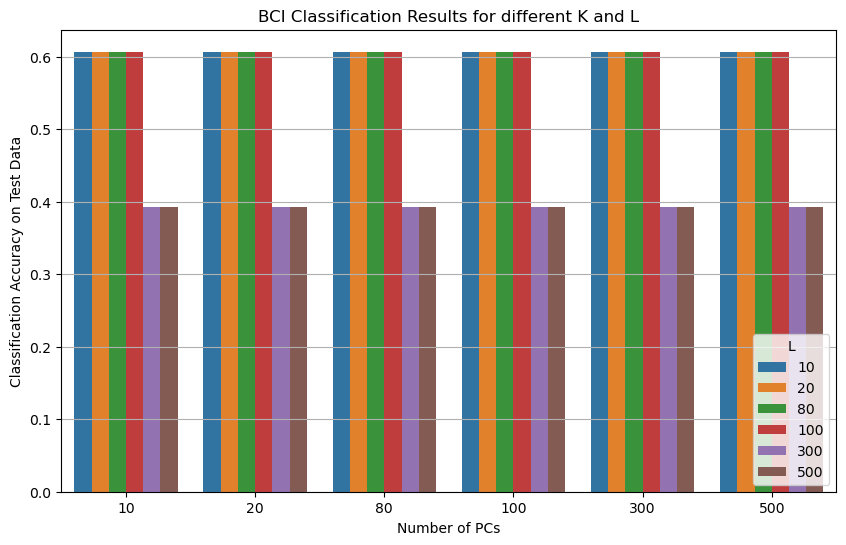

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x='K', y='Accuracy', hue='L', data=accuracy)
plt.xlabel('Number of PCs')
plt.ylabel('Classification Accuracy on Test Data')
plt.title('BCI Classification Results for different K and L')
plt.grid(axis='y')
plt.legend(title='L', loc='lower right') # bbox_to_anchor=(0.9, 0.45),
plt.show()